In [547]:



from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import math
import collections
import wfdb



In [548]:
#DETECT AND FLAG ARTIFACTS IN SIGNALS

def detectABPArtifact(record):
    """
    Using a more restrictive approach then Sun et al. 
    
    Condition 1: SBP >= 300 or SBP <= 20
    Condition 2: SBP - DBP <= 5
                 SBP - DBP > 200
    
    Condition 3: DBP <=5 or DBP >= 225
    
    Condition 4: BP beat-to beat > 20mmhg for Ps,Pd, mean
    
    Condition 5: += 80 mmhg / min change
    
    Note: not complete for 1Hz condition 5, need to determine how to downsample to 1/60Hz
    """

    
    def getSignal(signal,record):
        try:
            ind = record['sig_name'].index(signal)
            units = record['units'][ind]
            return record['p_signal'][:,ind],units
        except:
            return None,None
    
    ABPsys,units = getSignal('ABP SYS',record)
    ABPdias,units2 = getSignal('ABP DIAS',record)
    ABPmean,units23 = getSignal('ABP MEAN',record)
    HR,units3 = getSignal('HR',record)
    
#     for beat in HR:
#         print(beat)
        
    if ABPsys is None:
        return False, False, True,[],{}
    
    
    flaggedDict = defaultdict(list)
    flagged = []
    
    assert units.lower() == 'mmhg'
    assert units2.lower() == 'mmhg'
    
    
    ## HEARTBEAT LIMITS
#     for index,sample in enumerate(HR):
#         if sample < 20 or sample > 200:
#             flagged.append(index)
    
    #Condition 1 - ABP Sys
    sysRangeArtifactPresent = False
    for index,sample in enumerate(ABPsys):
        if sample >= 300 or sample <= 20:
            sysRangeArtifactPresent = True
            flagged.append(index)
            flaggedDict[index].append('ABP SYS')
            
            
    #Condition 3 - ABP Dias
    diasRangeArtifactPresent = False
    for index,sample in enumerate(ABPdias):
        if sample >= 225 or sample <= 5:
            diasRangeArtifactPresent = True
            flagged.append(index)
            flaggedDict[index].append('ABP DIAS')
            
            
    #Condition 2 - SYS vs DIAS
    sysDiasConflict = False
    for index,sys in enumerate(ABPsys):
        if sys - ABPdias[index] <= 5 or sys - ABPdias[index] > 200:
            sysDiasConflict =True
           
            flagged.append(index)
            flaggedDict[index].append('ABP DIAS')
            flaggedDict[index].append('ABP SYS')
    
    
    
    def detectDelta(signal,delta):
        flaggedsig = []
        for index, sigVal in enumerate(signal[:-1]):
            if not np.isnan(sigVal) and not np.isnan(signal[index+1]):
                if abs(signal[index+1] - sigVal) > delta:
                    #flaggedsig.append(index)
                    flaggedsig.append(index+1)
        return flaggedsig
    
    # Condition 4 -         
    sf = getSF(record)
    largeChange = False
    if sf == 1:
        
        flaggedABPsys = detectDelta(ABPsys,20)
        flaggedABPdias = detectDelta(ABPdias,20)
        flaggedABPmean = detectDelta(ABPmean,20)
        flaggedHR = detectDelta(HR,20)
        flagged.append(flaggedABPsys)
        flagged.append(flaggedABPdias)
        flagged.append(flaggedABPmean)
        flagged.append(flaggedHR)
        
        for i in flaggedABPsys:
            flaggedDict[i].append('ABP SYS')
        for i in flaggedABPdias:
            flaggedDict[i].append('ABP DIAS')
        for i in flaggedABPmean:
            flaggedDict[i].append('ABP MEAN')
        for i in flaggedHR:
            flaggedDict[i].append('HR')
        
    
    
    #Condition 5
    if sf < 1:
        
        flaggedABPsys = detectDelta(ABPsys,80)
        flaggedABPdias = detectDelta(ABPdias,80)
        flaggedABPmean = detectDelta(ABPmean,80)
        flagged.append(flaggedABPsys)
        flagged.append(flaggedABPdias)
        flagged.append(flaggedABPmean)
        flaggedHR = detectDelta(HR,80)
        flagged.append(flaggedHR)
        
        for i in flaggedABPsys:
            flaggedDict[i].append('ABP SYS')
        for i in flaggedABPdias:
            flaggedDict[i].append('ABP DIAS')
        for i in flaggedABPmean:
            flaggedDict[i].append('ABP MEAN')
        for i in flaggedHR:
            flaggedDict[i].append('HR')
    
    def flatten(l):
        for el in l:
            if isinstance(el, collections.Iterable) and not isinstance(el, (str, bytes)):
                yield from flatten(el)
            else:
                yield el
#     for key in flaggedDict:
#         print(key,flaggedDict[key])
    return sysRangeArtifactPresent,diasRangeArtifactPresent,largeChange,flatten(flagged),flaggedDict
    
    
    
    

In [ ]:
## PLOT RECORD SIGNALS

def startOfSignal(signal,record_dict):
    try:
        index = record_dict['sig_name'].index(signal)
    except:
        return "Error: signal not present"
                            
    signals = record_dict['p_signal']
    aSignal = signals[:,index]
    for index,sample in enumerate(aSignal):
        if not np.isnan(sample):
            return index

def getSignal(signal,record):
    ind = record['sig_name'].index(signal)
    units = record['units'][ind]
    return record['p_signal'][:,ind],units

def getSF(record):
    return record['fs']


def window(x,y,start,end):
    return x[start:end],y[start:end]

def formatSignal(signal,windowMin):
    samples = len(signal)
    x = [i for i in range(samples)]
    return x,signal
    

def movingaverage(interval, window_size):
    window = numpy.ones(int(window_size))/float(window_size)
    return numpy.convolve(interval, window, 'same')

def plotSignal(signalName,record,windowMin = 300,N = 5,movingAverage = False):
    plt.figure(figsize=(25,8))
    signal,units = getSignal(signalName,record)
    sf = getSF(record)
    timeUnit = 'min' if sf < 1 else 'sec'
    start = startOfSignal(signalName,record)
    #signal = window(signal, 5680,5690)
                           
    x,y = formatSignal(signal,windowMin)
    #x,y = window(x,y,6000,6010)
    tup = (x,y,signalName)
    plots = []
    plots.append(tup)
#     if signalName != 'HR':
#         for index,val in enumerate(signal):
#             print(index,val)
 
    if movingAverage:
        mAvgNP= np.convolve(y, np.ones((N,))/N, mode='valid')
        mAvgNP = [i for i in mAvgNP]
        padding = [np.nan] * (N-1)
        mAvg = padding + mAvgNP
        title = 'Moving Average with {} {} window'.format(N,timeUnit)
        tupl = (x,mAvg,title)
        plots.append(tupl)
    
    
    
    for plot in plots:
        #x,y = window(plot[0],plot[1],1000,2500)
        plt.plot(plot[0],plot[1],label = plot[2])
            
#     for index, val in enumerate(x)        
                            
    sysrange,diasrange,lgdelta,flagged,flaggedDict = detectABPArtifact(record)
    if sysrange:
        if signalName == 'ABP SYS':
            plt.axhline(y=300, color='r', linestyle='dashed')
            plt.axhline(y =20,color = 'r',linestyle = 'dashed')
            
    if diasrange:
        if signalName == 'ABP DIAS':
            plt.axhline(y=225, color='r', linestyle='dashed')
            plt.axhline(y =5,color = 'r',linestyle = 'dashed')
    
    
#     for xc in flagged:
#         plt.axvline(x=xc,color='r')
        
    for key in flaggedDict:
        if signalName in flaggedDict[key]:
            plt.axvline(x=key,color='r')
        
#     for key in flaggedDict:
#         print(key,flaggedDict[key])
    
    plt.title('{} Signal'.format(signalName))
    plt.xlabel('time ({})'.format(timeUnit))
    plt.ylabel(units)      
    legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')   
    plt.legend()
    
    plt.xlim(2000,2500)
    plt.show()                           
    

    
    
file = '/Users/Arcrank/Documents/Work/mimic3wdb/matched_numeric/p03/p032447/p032447-2170-04-17-16-46n'

    
def generatePlots(file):
    r = wfdb.rdrecord(file)
    a = r.__dict__
    hr = plotSignal('HR',a,movingAverage=True)
    #pul = plotSignal('PULSE',a,movingAverage=False)
    abps = plotSignal('ABP SYS',a,movingAverage=True)
    nbps = plotSignal('ABP DIAS',a,movingAverage=True)
    mabp = plotSignal('ABP MEAN',a,movingAverage=True)


    
    
def gensecondPlots(file):
    r = wfdb.rdrecord(file)
    a = r.__dict__
    hr = plotSignal('HR',a,movingAverage=True)
    #pul = plotSignal('PULSE',a,movingAverage=False)
    abps = plotSignal('ABP Sys',a,movingAverage=True)
    nbps = plotSignal('ABP Dias',a,movingAverage=True)
    mabp = plotSignal('ABP Mean',a,movingAverage=True)
    mabp = plotSignal('NBP Mean',a,movingAverage=True)
    mabp = plotSignal('NBP Dias',a,movingAverage=True)
    mabp = plotSignal('NBP Sys',a,movingAverage=True)
    mabp = plotSignal('RESP',a,movingAverage=True)

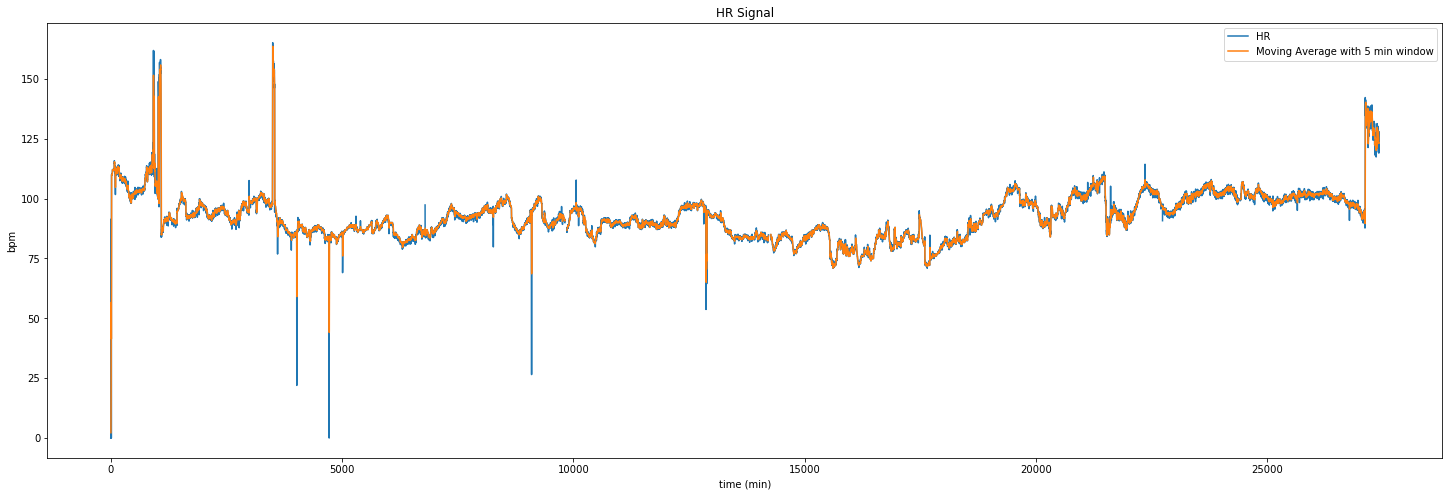

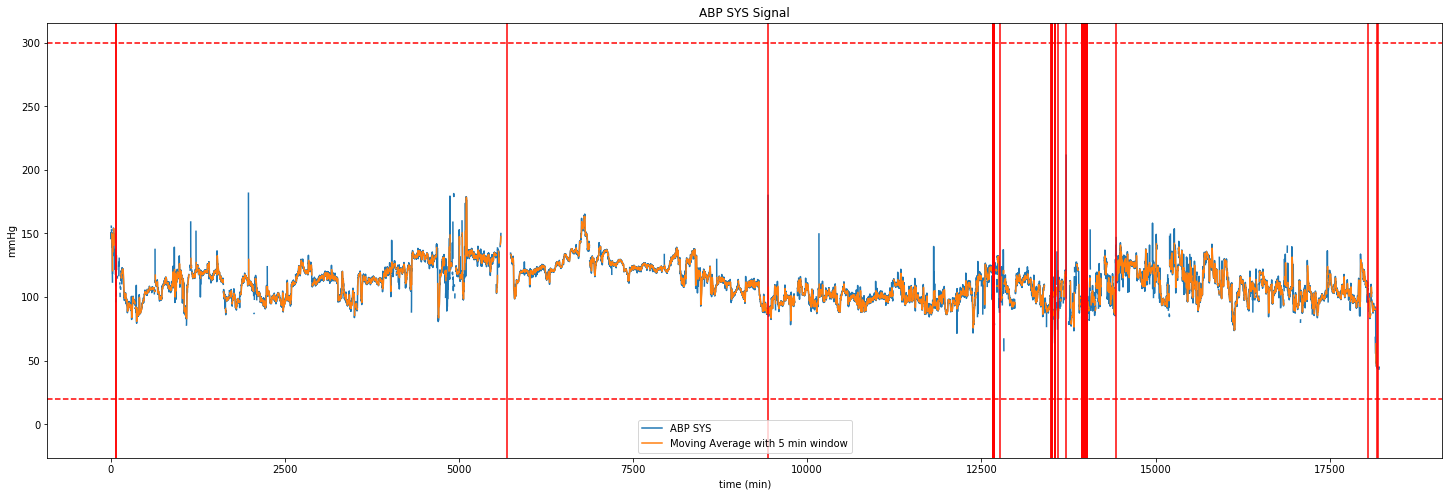

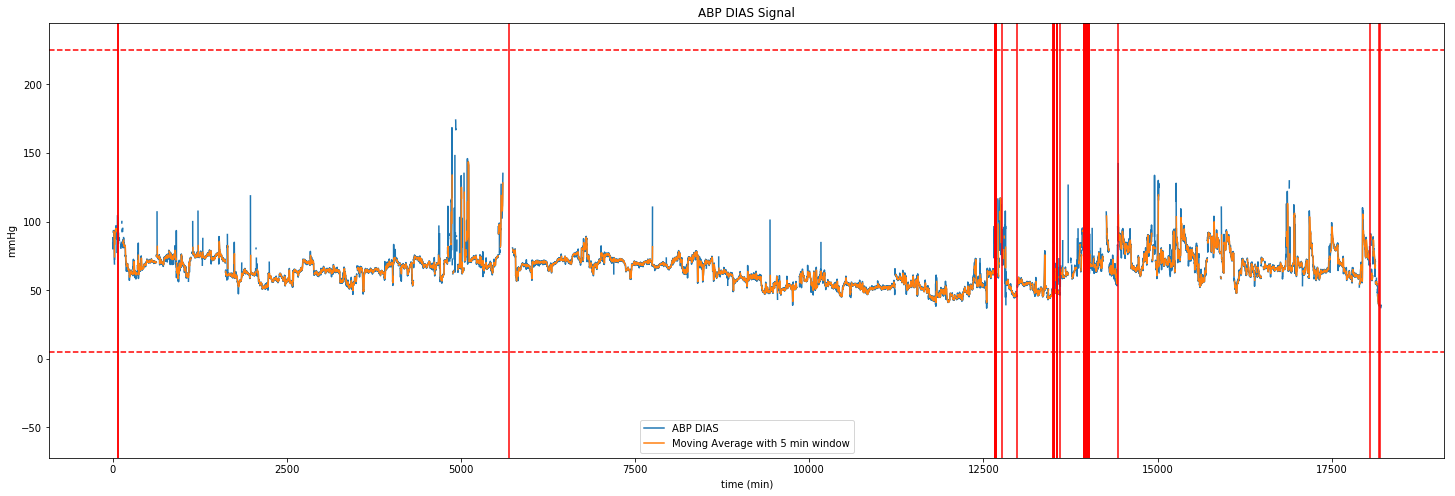

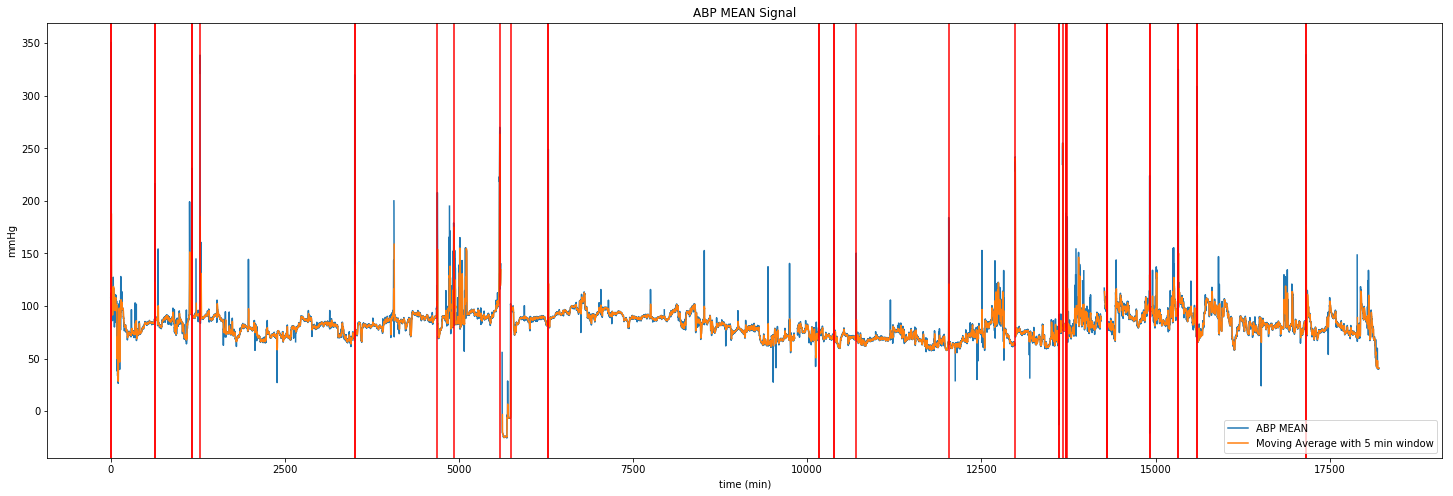

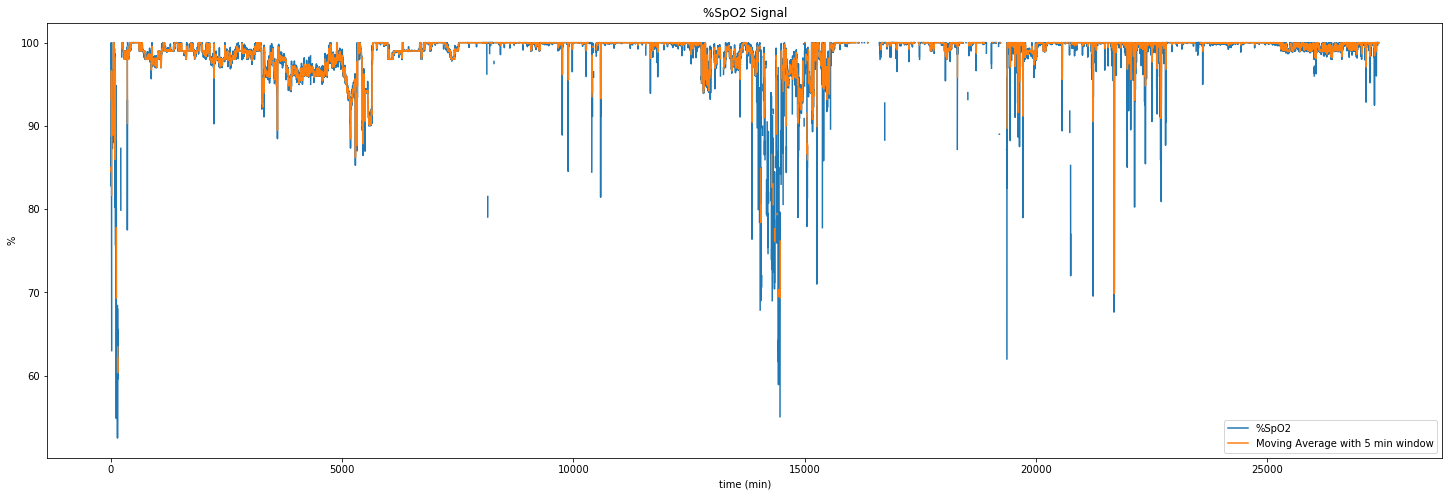

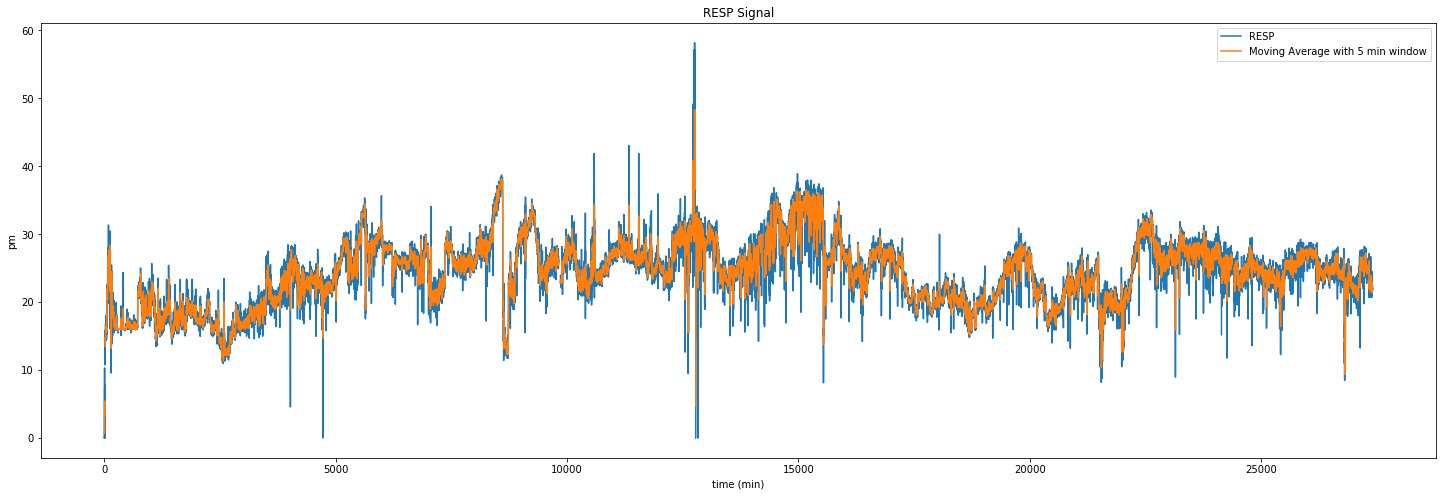

In [584]:
generatePlots(file)

### generatePlots('/Users/Arcrank/Documents/Work/mimic3wdb/matched_numeric/p03/p031782/p031782-2110-01-07-01-53n')

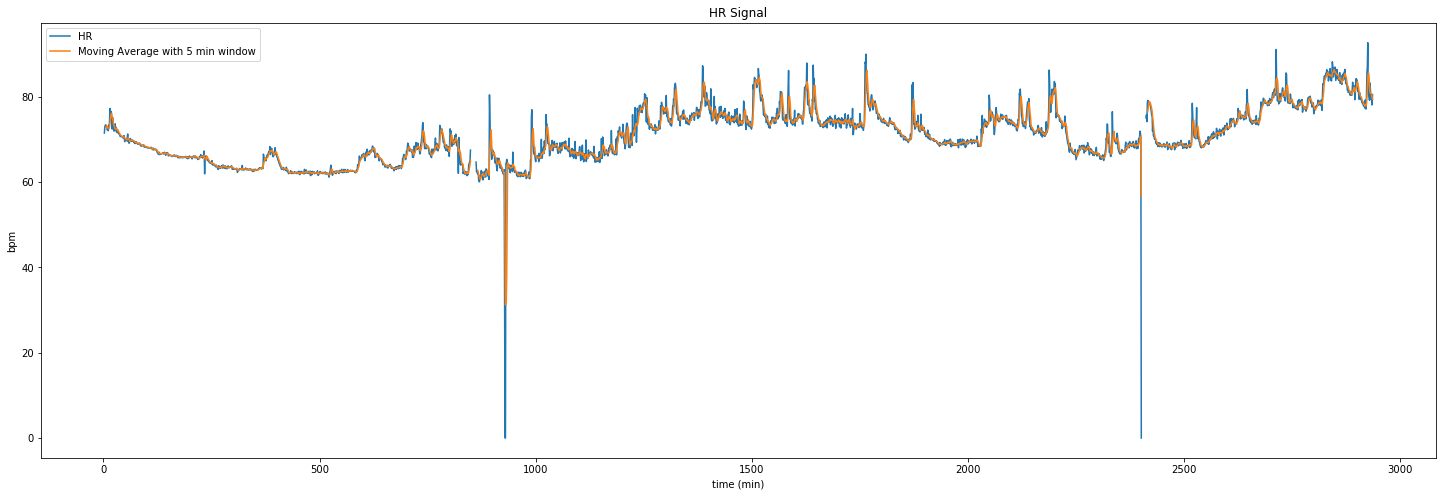

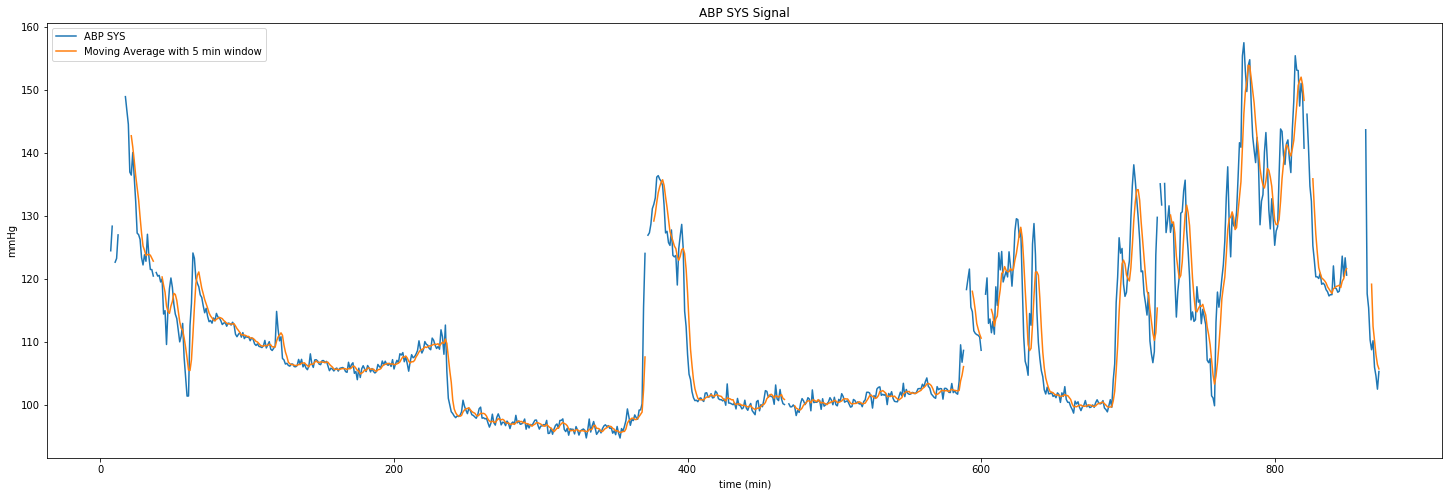

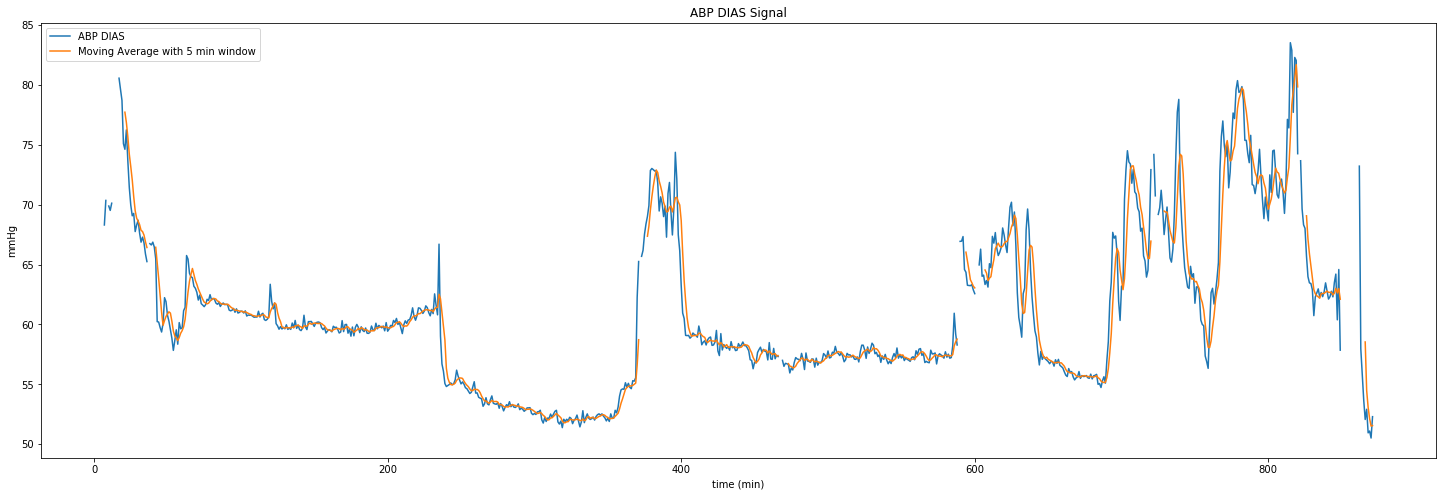

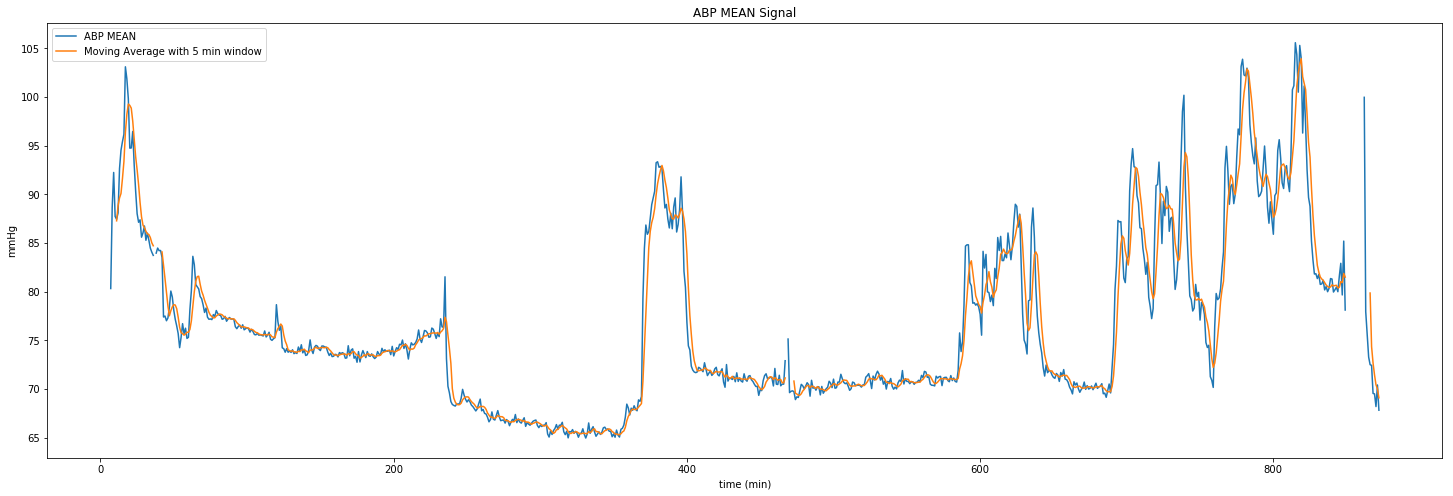

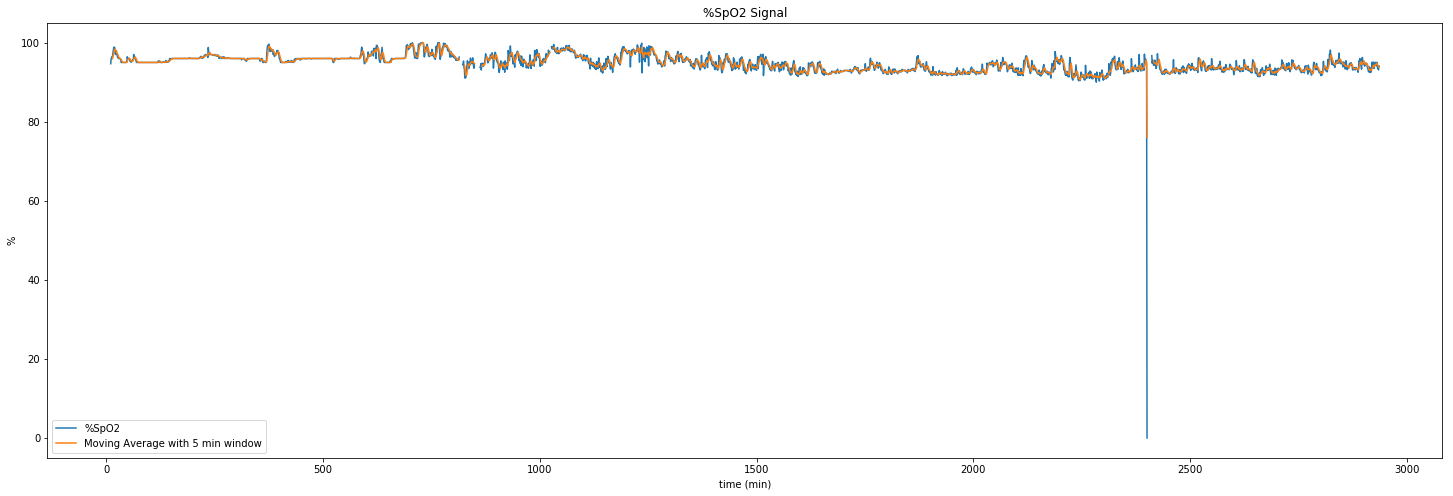

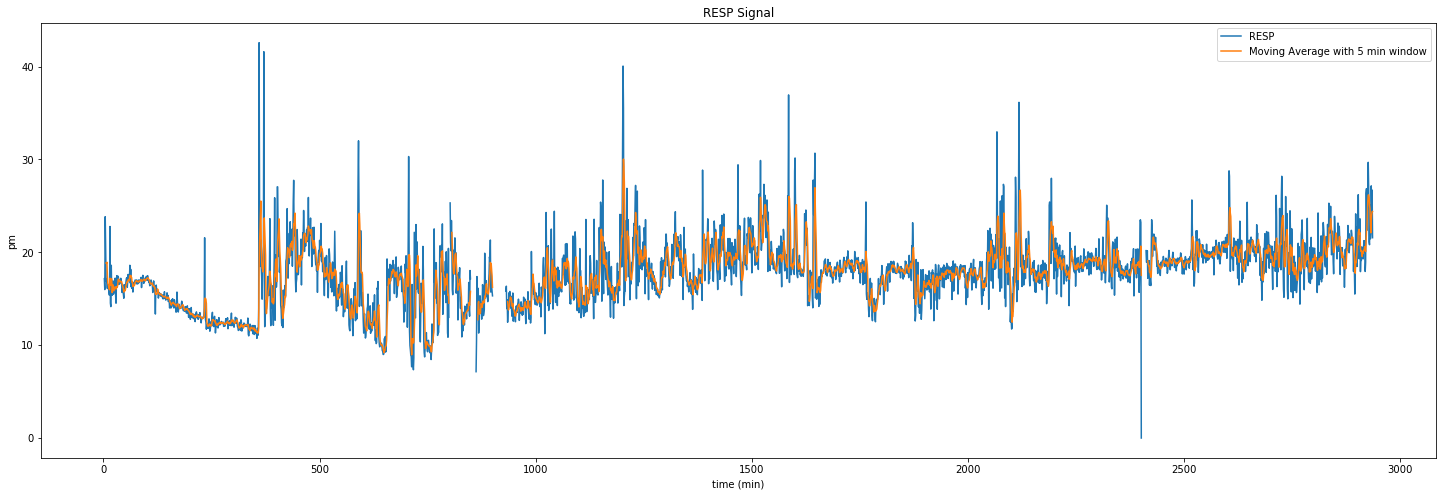

In [585]:
generatePlots('/Users/Arcrank/Documents/Work/mimic3wdb/matched_numeric/p03/p031062/p031062-2154-07-15-19-45n')

### gensecondPlots('/Users/Arcrank/Documents/Work/mimic3wdb/matched_numeric/p03/p031171/p031171-2121-03-19-15-56n')

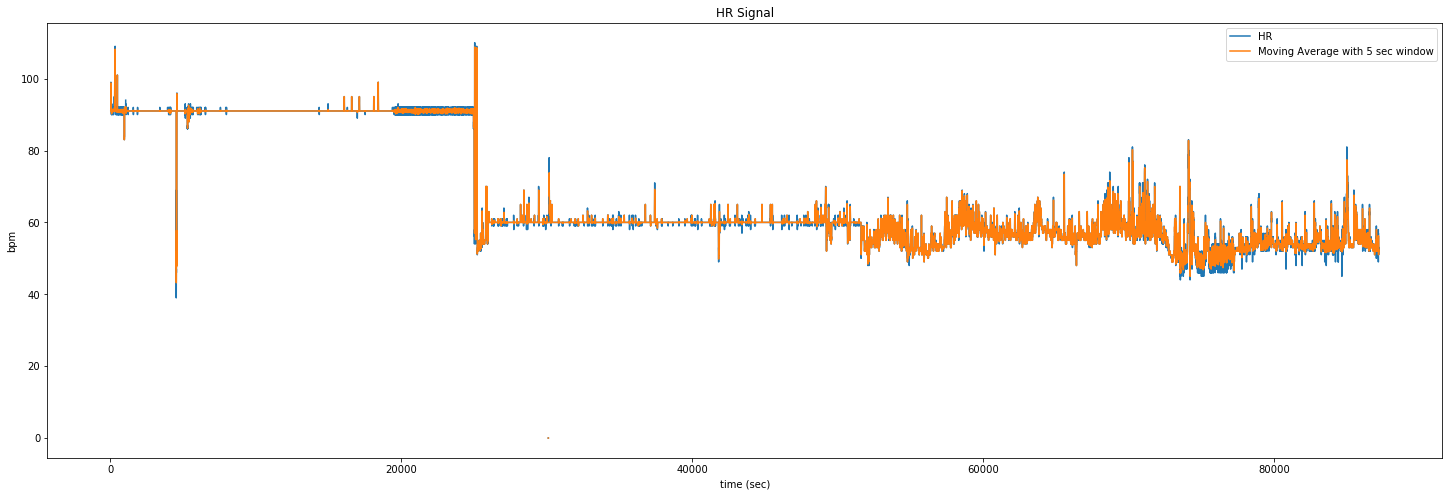

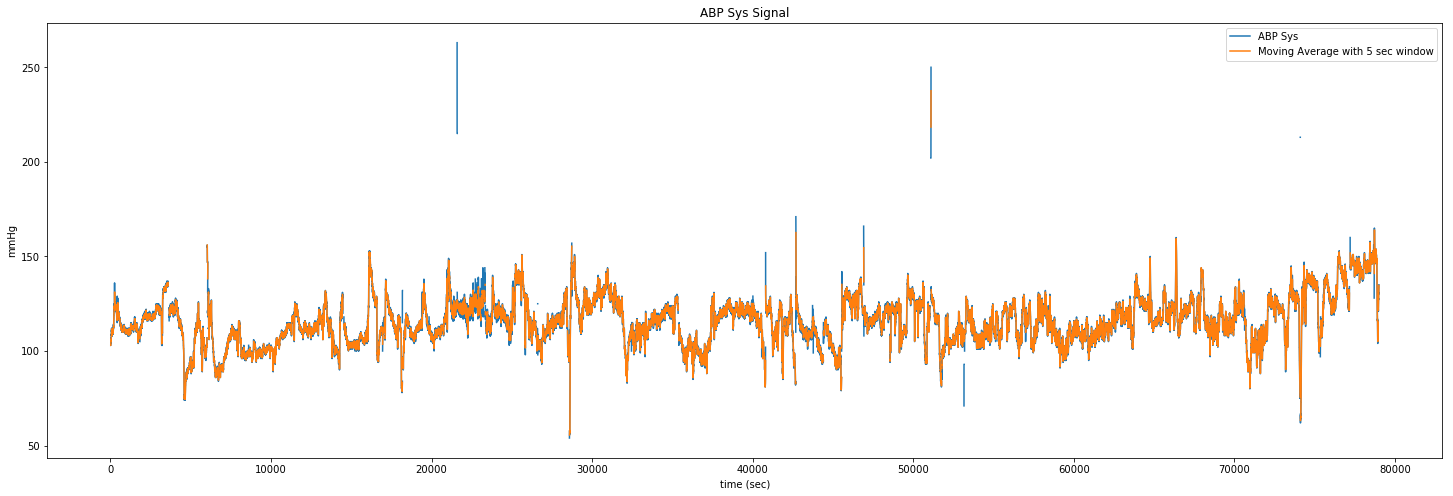

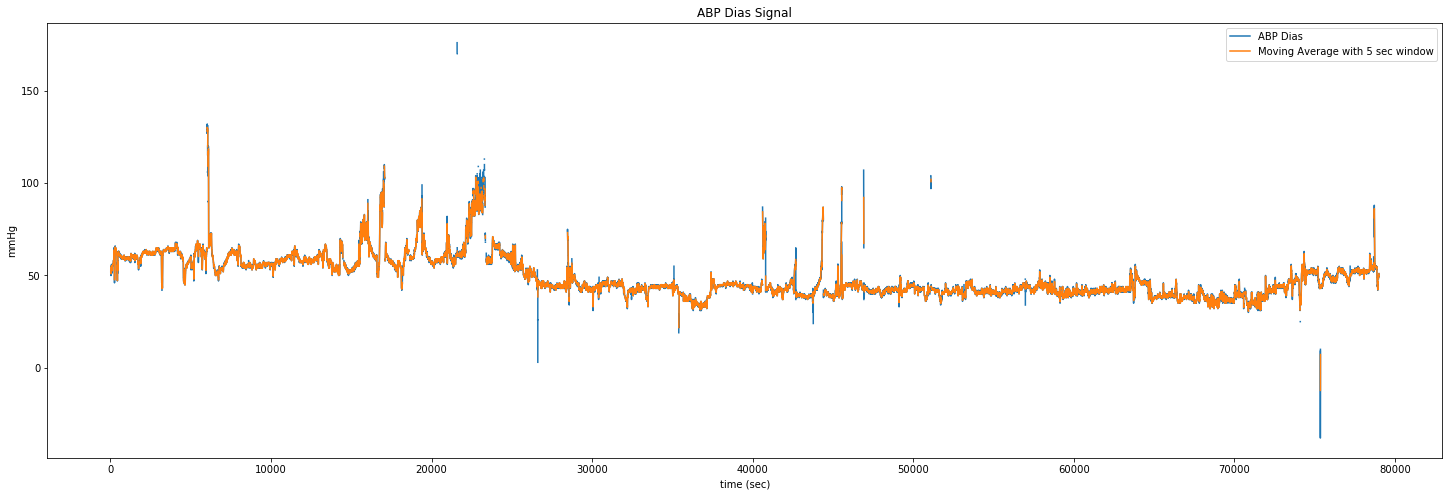

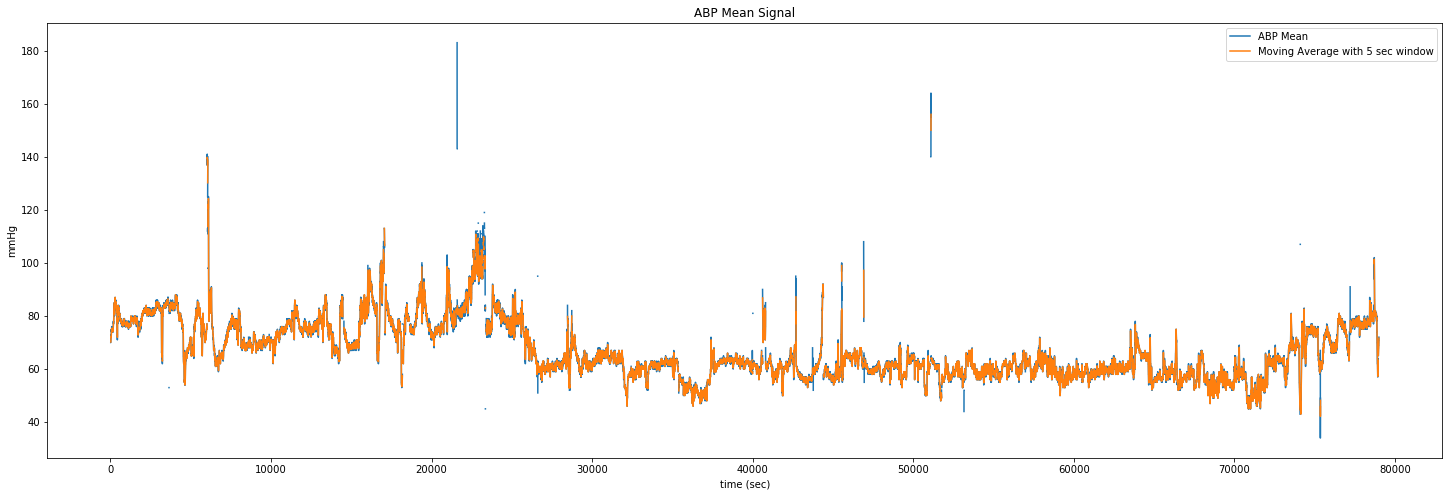

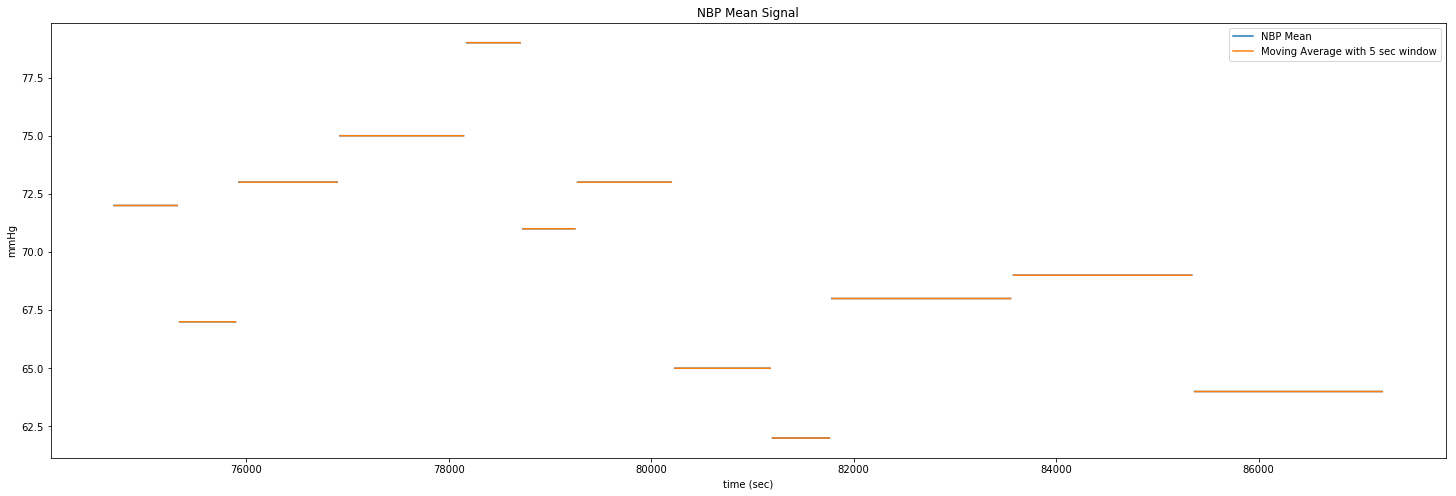

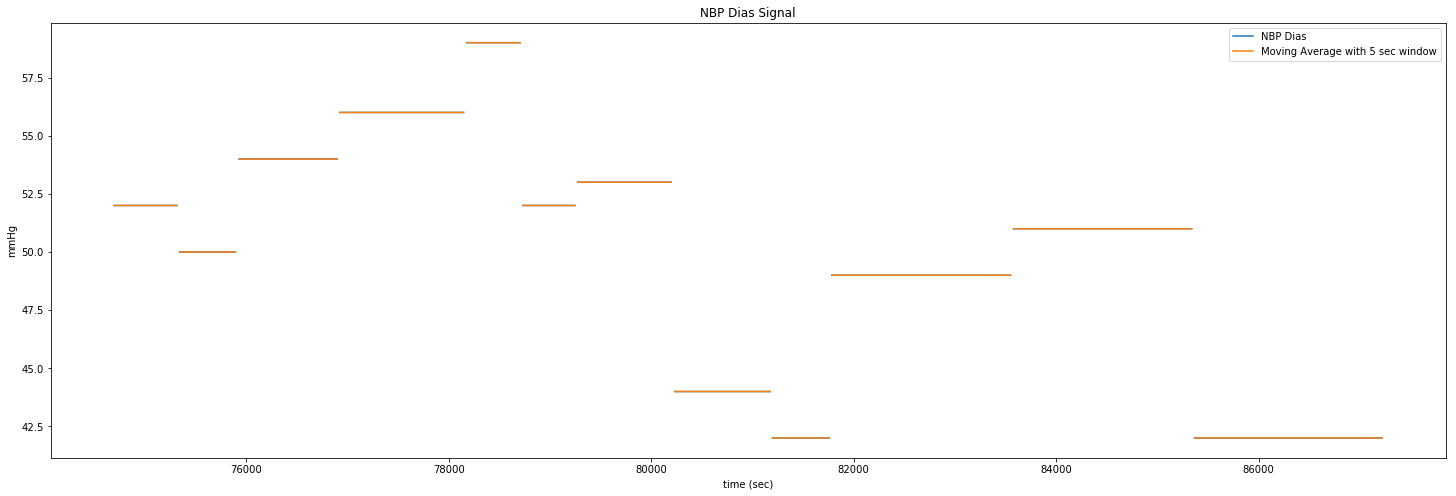

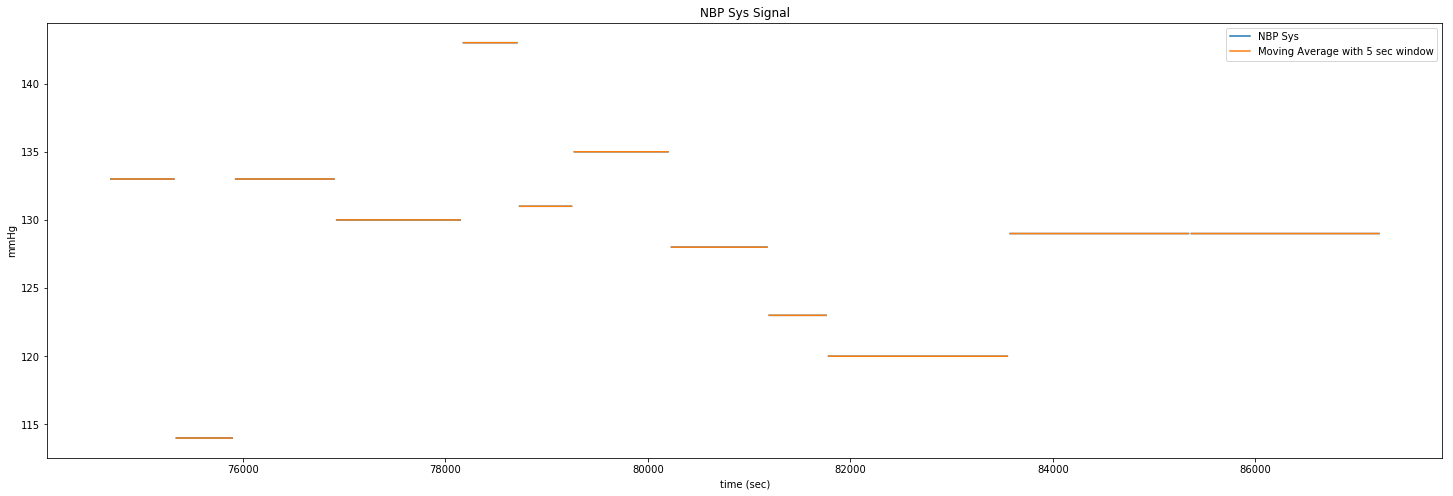

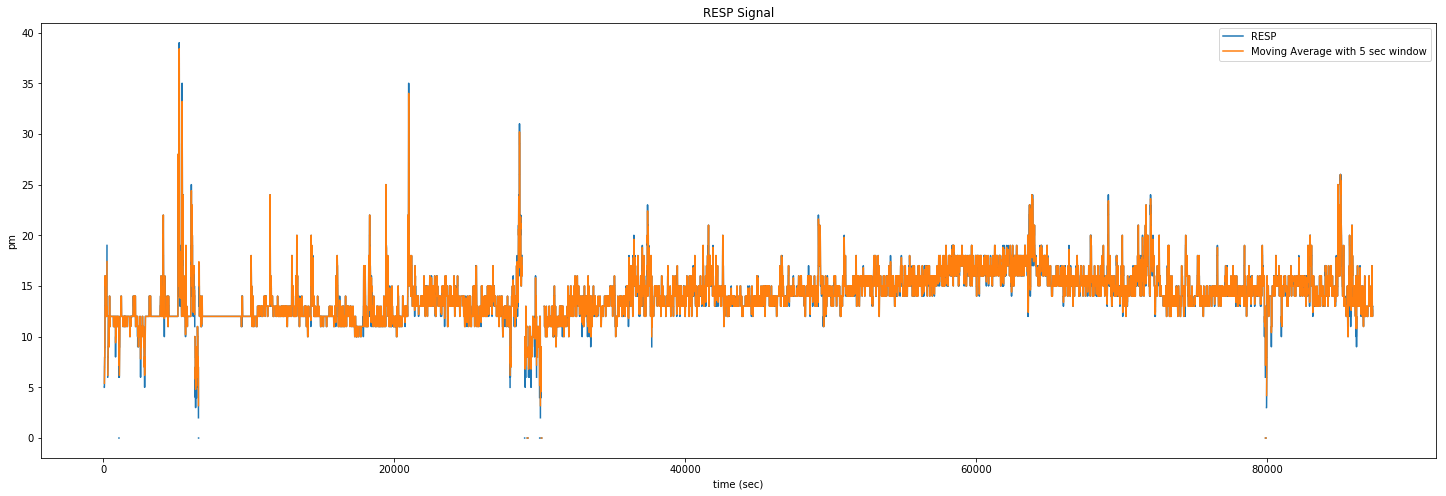

In [587]:
gensecondPlots('/Users/Arcrank/Documents/Work/mimic3wdb/matched_numeric/p03/p032067/p032067-2122-05-12-13-15n')


In [ ]:

def getSF(record):
    return record['fs']


dira = '/Users/Arcrank/Documents/Work/mimic3wdb/matched_numeric/p03/'
from collections import defaultdict
patients = os.listdir(dira)
samplef = defaultdict(int)
for patient in patients:
    patientPath = os.path.join(dira,patient)
    records = [file for file in os.listdir(patientPath) if file.endswith('n.hea')]
    
    for record in records:
        recordPath = os.path.join(patientPath,record)
        recordFile =  recordPath[:-4]
        record2 = wfdb.rdrecord(recordFile)
        record1 = record2.__dict__
        a = float(getSF(record1))
        if a < 1:
            s,di,d,flagged,fd = detectABPArtifact(record1)
            print(record,a,s,di,d,flagged,record1['sig_name'])
    

In [ ]:
class recordPlot():
    
    def __init__(self,record,signals = ['ABP SYS','ABP DIAS'],windowMin = 5,start = 0,end = -1,N= 5,extras = False
                figsize=(20,6)):
        self.signal = signal
        self.record = wfdb.rdrecord(record).__dict__
        self.windowMin = windowMin
        self.start = start
        self.end = end
        self.N = N
        self.extras = extras
        self.figsize = figsize
        self.signal,self.units = getSignal(self.signal,self.record)
        self.sf = record['fs']
        self.timeunits = 'min' if round(self.sf,3) == .0167 else 'sec' if self.sf == 1 else 'Unknown'
        
        
        def getSignal(signal,record):
            ind = record['sig_name'].index(signal)
            units = record['units'][ind]
            return record['p_signal'][:,ind],units
        
        
        
        

In [ ]:
def window(x,y,start,end):
    return x[start:end],y[start:end]

def formatSignal(signal,windowMin):
    samples = len(signal)
    x = [i for i in range(samples)]
    return x,signal
    
#plt.figure(figsize=(20,6))

def movingaverage(interval, window_size):
    window = numpy.ones(int(window_size))/float(window_size)
    return numpy.convolve(interval, window, 'same')

def plotSignal(signalName,record,windowMin = 300,N = 30,movingAverage = False):
    plt.figure(figsize=(20,6))
  #  signal,units = getSignal(signalName,record)
    sf = getSF(record)
    start = startOfSignal(signalName,record)
    #signal = window(signal, 5680,5690)
                           
    x,y = formatSignal(signal,windowMin)
    #x,y = window(x,y,6000,6010)
    tup = (x,y,signalName)
    plots = []
    plots.append(tup)
 
    if movingAverage:
        mAvgNP= np.convolve(y, np.ones((N,))/N, mode='valid')
        mAvgNP = [i for i in mAvgNP]
        padding = [np.nan] * (N-1)
        mAvg = padding + mAvgNP
        title = 'Moving Average with {} min window'.format(N)
        tupl = (x,mAvg,title)
        plots.append(tupl)
                      
    for plot in plots:
        x,y = window(plot[0],plot[1],6000,6010)
        plt.plot(x,y,label = plot[2])
            
#     for index, val in enumerate(x)        
                            
    #plt.plot(y,x)
#     if signalName == 'ABP SYS':
#         plt.axhline(y=300, color='r', linestyle='-') 
#     if signalName == 'ABP DIAS':
#         plt.axhline(y=225, color='r', linestyle='-') 
    plt.title('{} Signal'.format(signalName))
    plt.xlabel('time (min)')
    plt.ylabel(units)      
    legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')   
    plt.legend()
    
    plt.show()                           
    

sub = plotSignal('ABP SYS',a,movingAverage=True)
bus = plotSignal('ABP DIAS',a,movingAverage=True)

In [ ]:
def convertSecToMin(signal,format='sampled'):
    outputSignal = []
    
    if format == 'sampled':
        for index,sample in enumerate(signal):
            if index % 60 == 0:
                outputSignal.append(sample)
        return outputSignal
    
    
            
    
    
    

In [ ]:
def signalCorrelation(record,signal1,signal2,window = False):
    
    recordfile = wfdb.rdrecord(record)
    record = recordfile.__dict__
    
    def getSignal(signal,record):
        ind = record['sig_name'].index(signal)
        units = record['units'][ind]
        return record['p_signal'][:,ind],units
    
    
    sig1,units1 = getSignal(signal1,record)
    sig2,units2 = getSignal(signal2,record)
    
    Za = zip(sig1,sig2)
    Z = []
    
    for row in Za:
        
        Z.append(list(row))
    
    Z = [[4,4],[5,5]]
    ii = np.flatnonzero(np.isfinite(Z[:,1:3]).all(1))

    ## The correlation coefficients for complete case analysis
    r,lcl,ucl = corr(Z[ii,1], Z[ii,2])

    print("Complete case analysis:")
    print("%.2f(%.2f,%.2f)" % (r, lcl, ucl))
    
    print(len(sig1),len(sig2))
    fullCorrelation = np.corrcoef(sig1,sig2)
    return fullCorrelation

file = '/Users/Arcrank/Documents/Work/mimic3wdb/matched_numeric/p03/p032226/p032226-2201-05-17-17-46n'

print(signalCorrelation(file,'HR','PULSE'))

    